In [1]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from data_wrangling import Results_data, Data_preparation
from collections import OrderedDict
from results_plotting import Sarima_predictions, line_plot_predictions, baseline_forecasts
from baseline_models import Baseline_previous, Baseline_average
plt.style.use('fivethirtyeight')

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [87]:
def plot_results(df):
    cross_val_scores = {}
    cross_val_scores['baseline_previous'] = df.iloc[0]['baseline_previous']
    cross_val_scores['baseline_average'] = df.iloc[0]['baseline_averages']
    cross_val_scores['sarima'] = df.iloc[0]['sarimax']
    cross_val_scores['sarimaX_fixed'] = df.iloc[2]['sarimax']
    cross_val_scores['sarimaX_variable'] = df.iloc[6]['sarimax']
    results = OrderedDict(sorted(cross_val_scores.items(), key=lambda t: t[0]))
    values = [v/1000. for v in results.values()]
    plt.figure(figsize=(8,6))
    plt.bar(range(len(results)),values, color='b', alpha=0.5,align='center')
    plt.xticks(range(len(results)), results.keys(),rotation=45)
    plt.ylabel('Cross validation RMSE [kWh]')
    plt.title(df.iloc[0]['project'])
    plt.show()
    pass
    

In [88]:
project_name = 'project_a1e0'
freq = 'H'
season = 24
path = '../../capstone_data/Azimuth/clean/{}'.format(project_name)

In [89]:
dp = Data_preparation(path,freq)
df = dp.get_data()
y = dp.create_variable(agg='sum',feature='power_all')
path_res = 'results/output_'+project_name+'_hourly'
results = Results_data(path_res).get_data().df
res_sarima = results[results['model']=='sarima']
res_sarimax = results[results['model']=='sarimaX']
res_sarimax

,project,model,test,baseline_previous,baseline_averages,sarimax,sarima_x_aic,sarimax_params,order,seasonal_order,beta_var
2,project_a1e0,sarimaX,0,31853.389926,63782.281087,31609.605079,NaN,"{'k_ma': 2, 'k_exog': 3, 'measurement_error': ...","(1, 0, 2)","(1, 0, 1, 2)",0
3,project_a1e0,sarimaX,1,111615.907913,118871.592219,104768.843278,NaN,"{'k_ma': 2, 'k_exog': 3, 'measurement_error': ...","(1, 0, 2)","(1, 0, 1, 2)",0
2,project_a1e0,sarimaX,0,31853.389926,63782.281087,26912.987256,20557.846116,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(1, 0, 1)","(0, 0, 0, 2)",1
3,project_a1e0,sarimaX,1,111615.907913,118871.592219,110081.291438,22179.827851,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(1, 0, 1)","(0, 0, 0, 2)",1


In [90]:
params_s = (res_sarima.iloc[0]['order'],res_sarima.iloc[0]['seasonal_order'])
params_sX = (res_sarimax.iloc[0]['order'],res_sarimax.iloc[0]['seasonal_order'])
params_sX_v = (res_sarimax.iloc[2]['order'],res_sarimax.iloc[2]['seasonal_order'])
print params_s
print params_sX

((0, 1, 1), (0, 0, 0, 2))
((1, 0, 2), (1, 0, 1, 2))


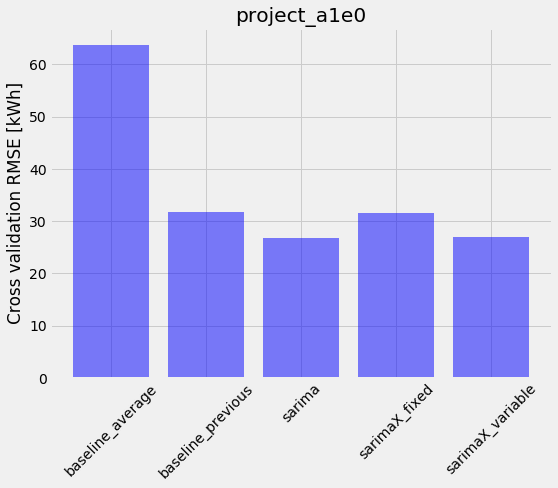

In [91]:
plot_results(results)

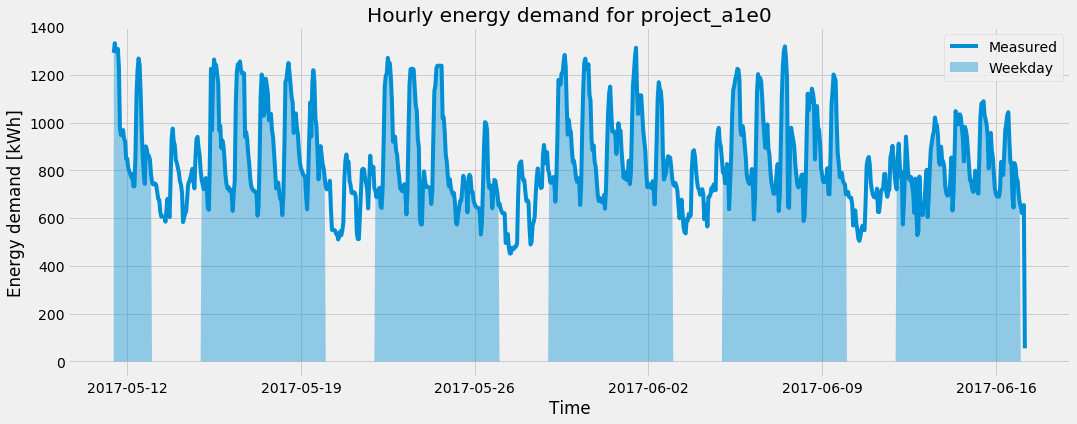

In [64]:
plt.figure(figsize=(16,6))
y_plot = y.iloc[:,0]/1000.
plt.plot(y.index, y_plot,label='Measured')
plt.fill_between(y.index, y.iloc[:,-1]*y_plot, alpha=0.4, label='Weekday')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Energy demand [kWh]')
title = 'Hourly energy demand for {}'.format(project_name)
plt.title(title)
plt.show()

## T-dependance

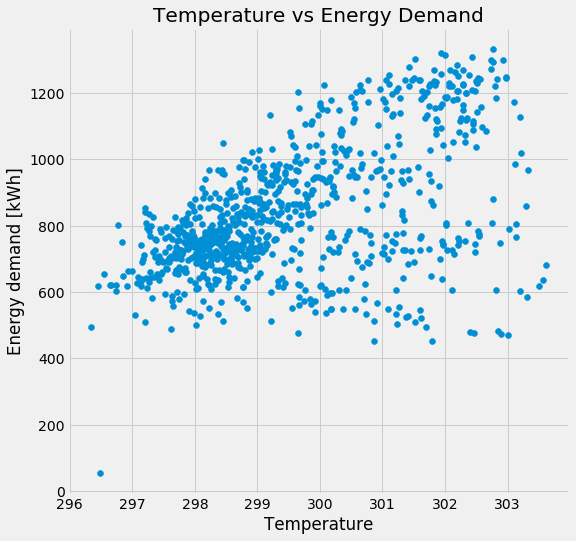

In [85]:
plt.figure(figsize=(8,8))
y_plot = y.iloc[:,0]/1000
plt.scatter(y.iloc[:,1], y_plot)
plt.xlabel('Temperature')
plt.ylabel('Energy demand [kWh]')
title = 'Temperature vs Energy Demand'.format(project_name)
plt.title(title)
plt.show()

In [66]:
y_train = y[:-2*season]
y_test = y[-2*season:]

In [67]:
endog = y_train.ix[:,0]
exog = sm.add_constant(y_train.ix[:,1:])

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


## Training

In [96]:
predictions = []

In [97]:
prediction_b1, prediction_b2 = baseline_forecasts(y_train,len(y_train)-(24*7),'H')


baseline - previous...
Baseline-previous test RMSE 80509.488072
baseline - averages....
Baseline-averages test RMSE 121350.036145


In [98]:
predictions.append(['baseline_previous',prediction_b1])
predictions.append(['baseline_average',prediction_b2])

In [100]:
# sarima
sp = Sarima_predictions(params_s)
model = sp.fit_sarima(endog)
pred = model.get_prediction(start=y_train.index.min()+(24*7), dynamic=False)
prediction_s = pred.predicted_mean.values
# sarimaX
sp = Sarima_predictions(params_sX)
model = sp.fit_sarimaX((endog, exog))
pred = model.get_prediction(start=y_train.index.min()+(24*7), dynamic=False)
prediction_sX = pred.predicted_mean.values
# sarimaX
sp = Sarima_predictions(params_sX_v)
model = sp.fit_sarimaX((endog, exog),var=True)
pred = model.get_prediction(start=y_train.index.min()+(24*7), dynamic=False)
prediction_sX_v = pred.predicted_mean.values

In [101]:
predictions.append(['sarima',prediction_s])
predictions.append(['sarimaX_f',prediction_sX])
predictions.append(['sarimaX_v',prediction_sX_v])

In [102]:
for pred in predictions:
    print len(pred[1])

666
666
666
666
666


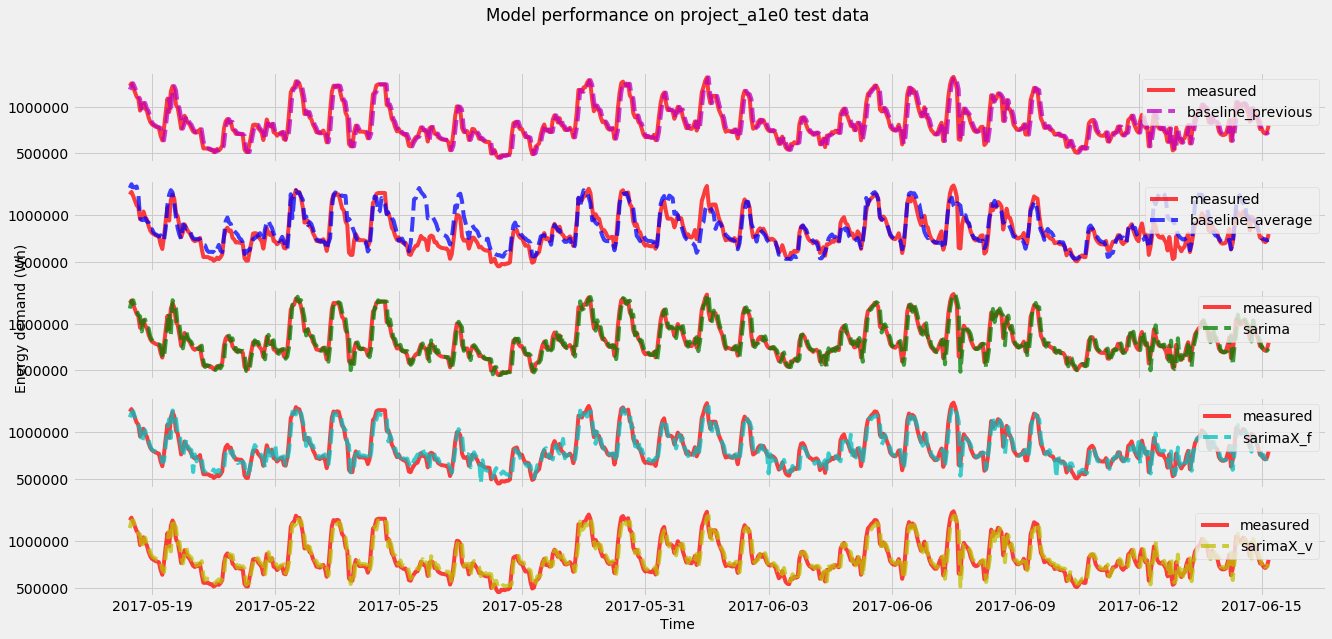

In [105]:
line_plot_predictions(project_name, predictions,y_train.iloc[24*7:])

In [106]:
sp = Sarima_predictions(params_sX)
model = sp.fit_sarimaX((y_train.iloc[:,0],y_train.iloc[:,1:]))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         power_all   No. Observations:                  834
Model:             SARIMAX(1, 0, 2)x(1, 0, 1, 2)   Log Likelihood              -10498.626
Date:                           Fri, 01 Sep 2017   AIC                          21013.252
Time:                                   18:53:56   BIC                          21051.062
Sample:                               05-11-2017   HQIC                         21027.749
                                    - 06-15-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T-1         2337.9153     65.084     35.921      0.000    2210.353    2465.478
weekday     1.874e+05   1.19e+04     15.705      0.000    1.64e+05    2.11e+05
ar.L1          0.6562      0.190      3.457      0.001       0.284       1.028
ma.L1          0.5297      0.189      2.800      0.005       0.159       0.901
ma.L2          0.0285      0.090      0.317      0.751      -0.148       0.205
ar.S.L2        0.3080      0.321      0.959      0.338      -0.322       0.938
ma.S.L2       -0.0702      0.152     -0.461      0.645      -0.368       0.228
sigma2      5.979e+09      0.102   5.89e+10      0.000    5.98e+09    5.98e+09
===================================================================================
Ljung-Box (Q):                      226.22   Jarque-Bera (JB):               362.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.04
Prob(H) (two-sided):                  0.30   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+26. Standard errors may be unstable.
"""

## Forecasts

In [107]:
forecasts = []

In [108]:
forecast_b1, forecast_b2 = baseline_forecasts(y,2*season,'H')


baseline - previous...
Baseline-previous test RMSE 111615.907913
baseline - averages....
Baseline-averages test RMSE 118871.592219


In [109]:
forecasts.append(['baseline_previous',forecast_b1])
forecasts.append(['baseline_average',forecast_b2])

In [111]:
sp = Sarima_predictions(params_s)
results_s = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=0)
sp = Sarima_predictions(params_sX)
results_sX = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2)
sp = Sarima_predictions(params_sX_v)
results_sX_v = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2,var=True)

In [112]:
forecast_s = results_s['sarima'][0]
forecast_sX = results_sX['sarimaX'][0]
forecast_sX_v = results_sX_v['sarimaX'][0]


In [113]:
forecasts.append(['sarima',forecast_s])
forecasts.append(['sarimaX_f',forecast_sX])
forecasts.append(['sarimaX_f_v',forecast_sX_v])

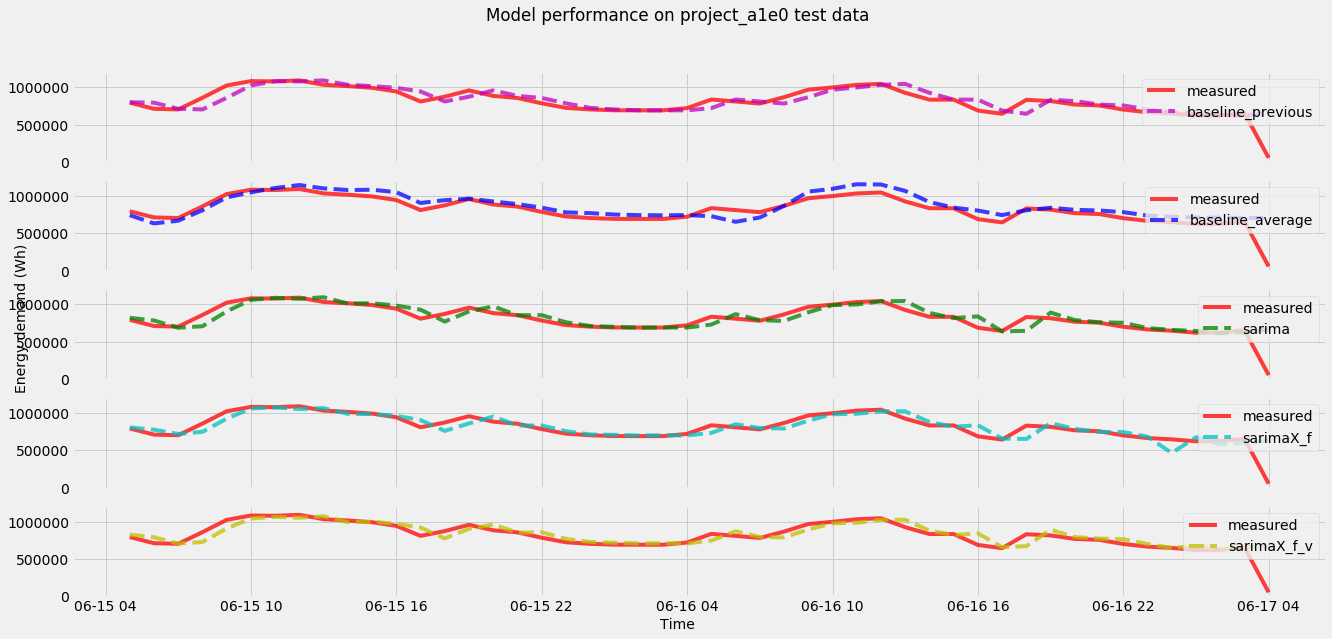

In [114]:
line_plot_predictions(project_name, forecasts,y_test)